# Machine Learning - Homework 1
## Mohammad Bahrami - 9724133

# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Union

# Question 1

## Defining the Normal Function

In [2]:
def normal(x, mean, dev):
    x = np.array(x)
    mean = np.array(mean)
    dev = np.array(dev)
    d = max(x.shape)

    out = 1 / ((2*np.pi)**(d/2) * np.linalg.det(dev)**(1/2)) * np.exp((-1/2)*(x-mean).T @ np.linalg.inv(dev) @ (x-mean))
    return out

## Part A
Reading the data into a pandas DataFrame

In [3]:
df = pd.read_csv('data1.csv')

Creating a new column in the DataFrame named `distro`, where it contains `1` for data points of a multi variate normal distribution with mean vector $\mu_1 = [5, 5]$ and covariance matrix $\Sigma = [[1, 0], [0, 1]]$ and contains `2` for data points of a multi variate normal distribution with mean vector $\mu_2 = [5, 5]$ and covariance matrix $\Sigma = [[1, 0], [0, 1]]$

In [4]:
df['dist'] = np.argmax([df.apply(lambda z: normal(z, [5,5],[[1,0],[0,1]]), axis=1), df.apply(lambda z: normal(z, [2,2],[[1,0],[0,1]]), axis=1)], axis=0) + 1

Creating two numpy arrays that contain the points of each distribution.

In [5]:
dist_1 = df.loc[df['dist'] == 1, ['x1', 'x2']].to_numpy()
dist_2 = df.loc[df['dist'] == 2, ['x1', 'x2']].to_numpy()

Ploting the distributions' points with different colors.

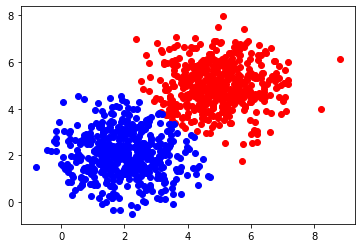

In [6]:
plt.plot(dist_1[:, 0], dist_1[:, 1], 'ro', dist_2[:, 0], dist_2[:, 1], 'bo')

## Part B
### Defining the Likelihood function

In [7]:
def Liklihood(X, Theta, precision: Union[np.float16, np.float32, np.float64, np.float128]=np.float128):
    X = np.array(X)
    L = np.prod(np.apply_along_axis(lambda z: normal(z, Theta[0], Theta[1]), 1, X), dtype=precision)
    return L

In [8]:
X1 = np.array(df[['x1', 'x2']].loc[df['dist'] == 1])
X2 = np.array(df[['x1', 'x2']].loc[df['dist'] == 2])

Trying the likelihood function for both distributions with different precisions.

First Distribution with Low precision

In [9]:
Liklihood(X1, ([5,5], [[1,0],[0,1]]), np.float64)

0.0

First Distribution with High precision

In [10]:
Liklihood(X1, ([5,5], [[1,0],[0,1]]), np.float128)

3.529926243641171416e-608

Second Distribution with Low precision

In [11]:
Liklihood(X2, ([2,2], [[1,0],[0,1]]), np.float64)

0.0

Second Distribution with High precision

In [12]:
Liklihood(X2, ([2,2], [[1,0],[0,1]]), np.float128)

1.2168647364633309208e-603

### Defining the Log Likelihood Function

In [13]:
def LogLiklihood(X, Theta):
    X = np.array(X)
    L = np.sum(np.log(np.apply_along_axis(lambda z: normal(z, Theta[0], Theta[1]), 1, X)))
    return L

There is no need for higher precision with `log` and `sum`.

In [14]:
LogLiklihood(X1, ([5,5], [[1,0],[0,1]]))

-1398.7104595638054

In [15]:
LogLiklihood(X2, ([2,2], [[1,0],[0,1]]))

-1388.26253341264

# Question 2

## Cost Functions

### Mean Square Error Cost Function

In [16]:
def MSE(X, Y, Theta):
    X = np.array(X)
    Y = np.array(Y)
    Theta = np.array(Theta)
    m = X.shape[0]
    J = 1 / (2*m) * np.sum(((X @ Theta) - Y)**2)
    return J

In [17]:
def MSEGrad(X, Y, Theta):
    X = np.array(X)
    Y = np.array(Y)
    Theta = np.array(Theta)
    m = X.shape[0]
    G = 1/m * (X.T @ (X @ Theta - Y))
    return G

### Mean Absolute Error Cost Function

In [18]:
def MAE(X, Y, Theta):
    X = np.array(X)
    Y = np.array(Y)
    Theta = np.array(Theta)
    m = X.shape[0]
    J = 1/m * np.sum(np.abs((X @ Theta) - Y))
    return J

In [19]:
def MAEGrad(X, Y, Theta):
    X = np.array(X)
    Y = np.array(Y)
    Theta = np.array(Theta)
    m = X.shape[0]
    G = 1/m * (X.T @ np.sign(X @ Theta - Y))
    return G

## Gradient Descent

In [20]:
def GradientDescentStep(X, Y, Theta, lr, cost_grad_fn):
    Theta = np.array(Theta)
    return Theta - lr * cost_grad_fn(X, Y, Theta)

In [21]:
def GD(X, Y, Theta_init, lr, batch_size, iterations, cost_fn, cost_grad_fn):
    Theta = np.array(Theta_init)
    X = np.array(X)
    Y = np.array(Y)
    J_history = []
    for i in range(iterations):
        batch_idxs = np.random.randint(X.shape[0], size=batch_size)
        Theta = GradientDescentStep(X[batch_idxs, :], Y[batch_idxs], Theta, lr, cost_grad_fn)
        J_history.append(cost_fn(X, Y, Theta))
    return Theta, np.array(J_history)

## Feature Normalization

In [22]:
def FeatureNormalization(X):
    mu = np.mean(X, axis=0)
    sigma = np.std(X, axis=0)
    return ((np.array(X) - mu) / sigma), mu, sigma

## Data
Now that we have the functions that we need, we can start answering the questions.

First we read the data into a numpy array and shuffle the data then, concatenate a column of ones to X to play the role of $X_0$.

In [23]:
dataset = pd.read_csv('insurance.csv').to_numpy()
np.random.shuffle(dataset)
X = np.concatenate((np.ones((dataset.shape[0], 1)), dataset[:, :-1]), axis=1)
Y = dataset[:, -1].reshape((-1, 1))

## Part A and B - GD, MiniBatch GD and SGD Comparison
**The Explanation is Given After Each Part of Code**

Now that the Data is ready, we can fit different types of models to our data. 

In [24]:
Theta_init = np.random.rand(X.shape[1], 1)

In [25]:
Theta_Batch, J_hist_Batch = GD(X, Y, Theta_init, 0.0001, X.shape[0], 120, MSE, MSEGrad)
Theta_MiniBatch, J_hist_MiniBatch = GD(X, Y, Theta_init, 0.0001, 16, 120, MSE, MSEGrad)
Theta_Stochastic, J_hist_Stochastic = GD(X, Y, Theta_init, 0.0001, 1, 120, MSE, MSEGrad)
t = np.arange(J_hist_Batch.shape[0])

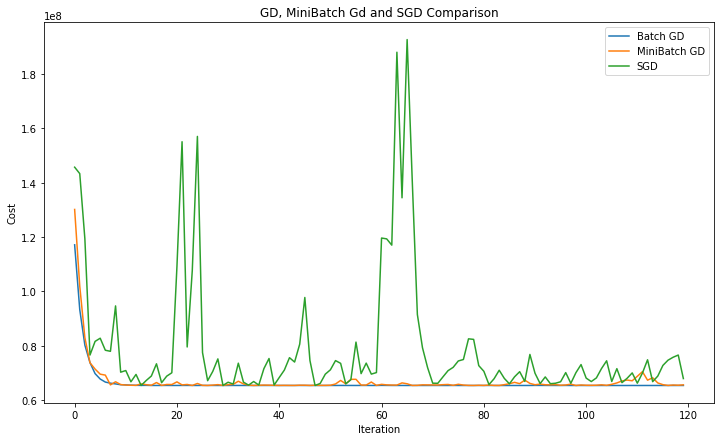

In [26]:
plt.plot(t, J_hist_Batch)
plt.plot(t, J_hist_MiniBatch)
plt.plot(t, J_hist_Stochastic)
plt.title('GD, MiniBatch Gd and SGD Comparison')
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.gcf().set_size_inches(12, 7)
plt.legend(['Batch GD', 'MiniBatch GD', 'SGD'])

As depicted, all methods reach near the optimal solution very quickly. We can see that SGD jumps around the optimal point but batch and mini batch gradient descent both have found the optimal point and stayed there. The reason that SGD's cost function is so noisy is that SGD is estimating a Gradient based on only one sample and this can make the parameters worse. because we need to make sure our gradient is based on all or some of the samples to have a good certainty that this move will be towards the optimal minima. Although SGD is very fast at getting close to optimal minima, it is not very good at finding the exact value of it. Often times the batch size is increased after a certain number of iterations to make the model more robust. Of course one most take this into consideration that each iteration of SGD needs the gradient of only one sample and is calculated very quickly, where as each iteration of GD or MiniBatch GD needs the calculation of all or some of the samples and will take longer than SGD.

Now we will repeat the last process with a smaller number of iterations so we can see the difference between GD and MiniBatch GD.

In [27]:
Theta_Batch, J_hist_Batch = GD(X, Y, Theta_init, 0.0001, X.shape[0], 20, MSE, MSEGrad)
Theta_MiniBatch, J_hist_MiniBatch = GD(X, Y, Theta_init, 0.0001, 16, 20, MSE, MSEGrad)
Theta_Stochastic, J_hist_Stochastic = GD(X, Y, Theta_init, 0.0001, 1, 20, MSE, MSEGrad)
t = np.arange(J_hist_Batch.shape[0])

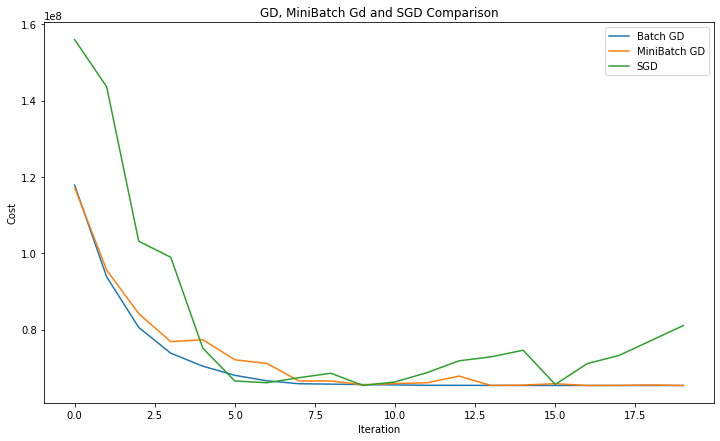

In [28]:
plt.plot(t, J_hist_Batch)
plt.plot(t, J_hist_MiniBatch)
plt.plot(t, J_hist_Stochastic)
plt.title('GD, MiniBatch Gd and SGD Comparison')
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.gcf().set_size_inches(12, 7)
plt.legend(['Batch GD', 'MiniBatch GD', 'SGD'])

We can see that the MiniBatch GD is almost as good as Batch GD at staying in the optimal minima and has much less noise than SGD's loss function. We can say that the MiniBatch GD has the good features of both GD and SGD and is both reliable and fast.

### Final Comparison
**Based On Iterations To Convergence**: GD < MiniBatch GD < SGD

**Based On Time To Convergence**: SGD | Minibatch GD < GD

**Based On Time of each Iteration**: SGD < MiniBatch GD < GD

**Based On Minimum Error**: GD < MiniBatch GD < SGD

## Part C - Zero and Random Parameter Initialization Comparison

In [29]:
Theta_Zero_init = np.zeros((X.shape[1], 1))
Theta_Rand_init = np.random.rand(X.shape[1], 1)

In [30]:
Theta_Zero, J_hist_Zero = GD(X, Y, Theta_Zero_init, 0.0001, X.shape[0], 30, MSE, MSEGrad)
Theta_Rand, J_hist_Rand = GD(X, Y, Theta_Rand_init, 0.0001, X.shape[0], 30, MSE, MSEGrad)
t = np.arange(J_hist_Zero.shape[0])

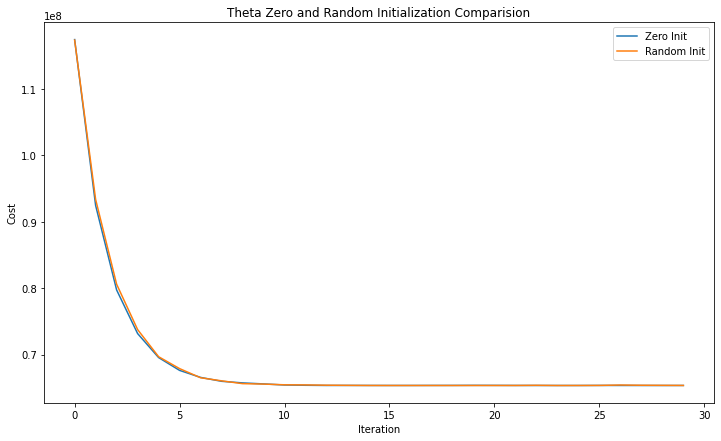

In [31]:
plt.plot(t, J_hist_Zero)
plt.plot(t, J_hist_Rand)
plt.title('Theta Zero and Random Initialization Comparision')
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.gcf().set_size_inches(12, 7)
plt.legend(['Zero Init', 'Random Init'])

The main reason that model parameters are randomized in most real world cases is that we want to avoid getting trapped in local optima and this randomization gives us the chance to start at different points towards the minima and increases the chance of finding the global optima. In our case, linear regression, however, the MSE cost function is always convex and has only one minima which is the global one. This is the reason that the above two lines are almost perfectly aligned. 

## Part D - MSE and MAE Comparison

In [32]:
Theta_init = np.random.rand(X.shape[1], 1)

In [33]:
Theta_MSE, J_hist_MSE = GD(X, Y, Theta_init, 0.0001, 1, 60, MSE, MSEGrad)
Theta_MAE, J_hist_MAE = GD(X, Y, Theta_init, 0.1, 1, 60, MAE, MAEGrad)
t = np.arange(J_hist_MSE.shape[0])

As the Scale of these lost functions is extremely different, we have to plot them on different figures.

Also The `MAE` and `MAEGrad` Functions have been implemented in a way that the gradient is present in all points. So I never had any problems with gradient to begin with. Also, Because of the scale difference that has been pointed out, the learning rate with MAE most be much bigger so the results can be comparable.

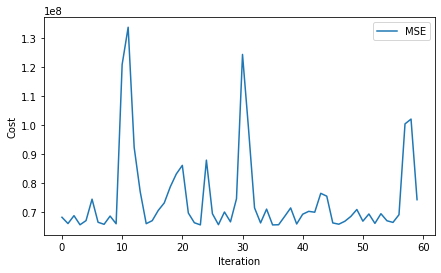

In [34]:
plt.plot(t, J_hist_MSE)
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.gcf().set_size_inches(7, 4)
plt.legend(['MSE'])

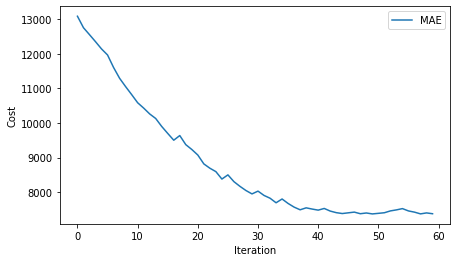

In [35]:
plt.plot(t, J_hist_MAE)
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.gcf().set_size_inches(7, 4)
plt.legend(['MAE'])


## Part E - Big Learning Rate

In [36]:
Theta_init = np.random.rand(X.shape[1], 1)

In [37]:
Theta_NormalLR, J_hist_NormalLR = GD(X, Y, Theta_init, 0.0001, X.shape[0], 30, MSE, MSEGrad)
Theta_BigLR, J_hist_BigLR = GD(X, Y, Theta_init, 0.00077, X.shape[0], 30, MSE, MSEGrad)
t = np.arange(J_hist_NormalLR.shape[0])

The amount of change that even barely changing the learning rate brings to the model is unbelievable. even changing the learning rate for 0.00001 when it is close to the border of being too big, will cause the cost function to go up very fast and reach extremely huge values. I have tuned the big learning rate to an amount that we can easily compare the result to the normal learning rate. changing the big learning rate will cause the values of two losses to become incomparable in scale. 

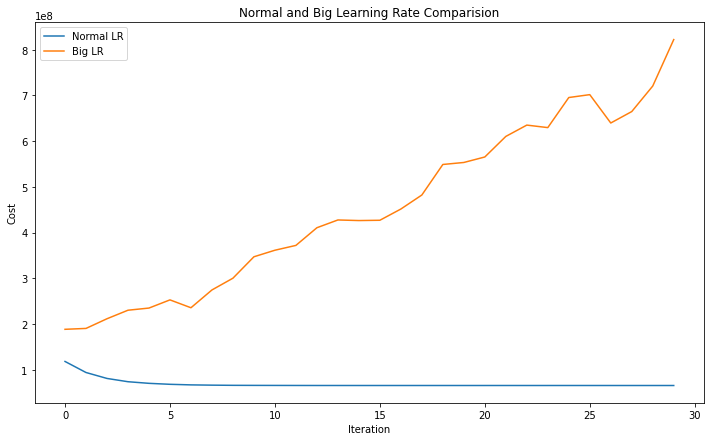

In [38]:
plt.plot(t, J_hist_NormalLR)
plt.plot(t, J_hist_BigLR)
plt.title('Normal and Big Learning Rate Comparision')
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.gcf().set_size_inches(12, 7)
plt.legend(['Normal LR', 'Big LR'])

We can see that when the learning rate is too big, the cost function will become noisy and start to diverge.

## Part F - Small Learning Rate

In [39]:
Theta_init = np.random.rand(X.shape[1], 1)

In [40]:
Theta_NormalLR, J_hist_NormalLR = GD(X, Y, Theta_init, 0.0001, X.shape[0], 30, MSE, MSEGrad)
Theta_BigLR, J_hist_BigLR = GD(X, Y, Theta_init, 0.00001, X.shape[0], 30, MSE, MSEGrad)
t = np.arange(J_hist_NormalLR.shape[0])

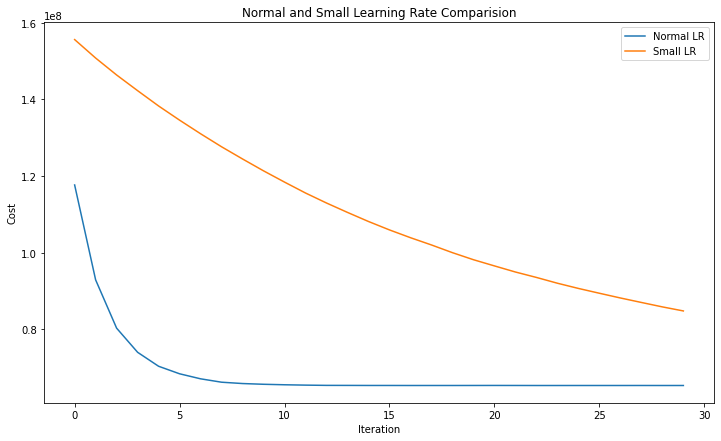

In [41]:
plt.plot(t, J_hist_NormalLR)
plt.plot(t, J_hist_BigLR)
plt.title('Normal and Small Learning Rate Comparision')
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.gcf().set_size_inches(12, 7)
plt.legend(['Normal LR', 'Small LR'])

As we can see, the slope of the cost function over time decreases when the learning rate is too small. A small learning rate will make the gradient steps too small and each step will not change the parameters effectively towards the optimal minima.

## Part G - Non-Normalized and Normalized Features Comparison

In [42]:
Theta_init = np.random.rand(X.shape[1], 1)
X_normed, mu, sigma = FeatureNormalization(X[:, 1:])
X_normed = np.concatenate((X[:, 0].reshape(-1,1), X_normed), axis=1)

In [43]:
Theta_X, J_hist_X = GD(X, Y, Theta_init, 0.0001, 1, 500, MSE, MSEGrad)
Theta_X_normed, J_hist_X_normed = GD(X_normed, Y, Theta_init, 0.01, 1, 500, MSE, MSEGrad)
t = np.arange(J_hist_X.shape[0])

Because the numbers in the Normalized data set are extremely smaller, we need to adjust the learning rate to a bigger number for the results to be comparable.

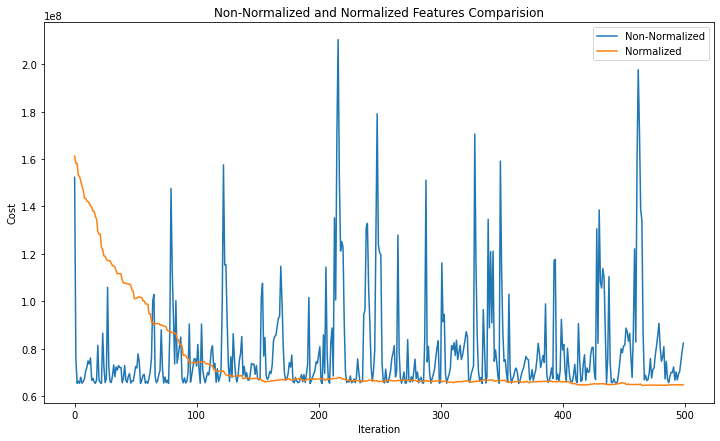

In [44]:
plt.plot(t, J_hist_X)
plt.plot(t, J_hist_X_normed)
plt.title('Non-Normalized and Normalized Features Comparision')
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.gcf().set_size_inches(12, 7)
plt.legend(['Non-Normalized', 'Normalized'])

As we can see, Normalizing the data considerably reduces the cost function noise of SGD and makes the SGD converge to the local minima very faster and makes it stay at the local optima instead of jumping around randomly. Moreover, Feature Normalization makes other types of GD faster too and more reliable. 